# Build the optimize model

In this notebook, we're going to create the optimize model using the dataset `df_loans_with_loans_repays_hist_and_trans_hist_per_user_cleared.csv` that is located at `./data/processed`. The algorithm chosen to optimize is the Random Forest, as it is based on an ensemble, it builds several "weak" decision trees but when seen their combined results ends up generating a strong model.

In [1]:
import os 
## Change to root dir
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import yaml


from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score,f1_score,classification_report
from sklearn.feature_selection import RFECV

from typing import Union
from pathlib import Path
from helper import *

/home/talissa/miniconda3/envs/loan_pred_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 - Data reading

In [3]:
train_data = pd.read_csv("./data/processed/train_data.csv")
test_data = pd.read_csv("./data/processed/test_data.csv")

## columns check
set(train_data.columns)==set(test_data.columns)

True

In [4]:
TARGET = "status"
NUM_FEATURES = list(train_data.select_dtypes(include=["float64"],exclude=["object","int64"]).columns)
CAT_FEATURES = [col for col in list(train_data.select_dtypes(include=["object"],exclude=["float64","int64"]).columns)
                if col not in ["date_created","reference_date","created_at","due_date",TARGET]]
FEATURES = NUM_FEATURES + CAT_FEATURES
FEATURES

['amount',
 'total_amount',
 'due_amount',
 'sum_amt_transactions_at_created_loan',
 'sum_amt_payment_method_credit_at_created_loan',
 'sum_amt_payment_method_debit_at_created_loan',
 'sum_amt_transactions_in_visa_at_created_loan',
 'sum_amt_transactions_in_mastercard_at_created_loan',
 'sum_amt_transactions_in_elo_at_created_loan',
 'max_amt_transactions_at_created_loan',
 'max_installments_at_created_loan',
 'median_installments_at_created_loan',
 'sum_amt_transactions_in_last_month',
 'sum_amt_payment_method_credit_in_last_month',
 'sum_amt_payment_method_debit_in_last_month',
 'sum_amt_transactions_in_visa_in_last_month',
 'sum_amt_transactions_in_mastercard_in_last_month',
 'sum_amt_transactions_in_elo_in_last_month',
 'max_amt_transactions_in_last_month',
 'max_installments_in_last_month',
 'median_installments_in_last_month',
 'avg_amt_transactions_in_last_three_months',
 'avg_amt_payment_method_credit_in_last_three_months',
 'avg_amt_payment_method_debit_in_last_three_months',


## 2 - Creating a non-optimized model 

Let's initially apply the features to a simple Random Forest model without trying to optimize the model for now.

In [5]:
X_train = train_data[NUM_FEATURES+CAT_FEATURES]
y_train = train_data[TARGET].map({"repaid":1,"debt":0})
X_test = test_data[NUM_FEATURES+CAT_FEATURES]
y_test = test_data[TARGET].map({"repaid":1,"debt":0})

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))
print("y_train proportion of repay and debt:",y_train.value_counts(normalize=True))
print("y_test proportion of repay and debt:",y_test.value_counts(normalize=True))

X_train, y_train shape: ((5963, 69), (5963,))
X_test, y_test: ((769, 69), (769,))
y_train proportion of repay and debt: status
1    0.741908
0    0.258092
Name: proportion, dtype: float64
y_test proportion of repay and debt: status
1    0.811443
0    0.188557
Name: proportion, dtype: float64


In [6]:
# Define the pipeline
# Create the column transformer

categorical_transformer = Pipeline(
    steps=[
        ('cat_imputer',SimpleImputer(strategy="most_frequent")),
        ('ohe_cat', OneHotEncoder())
        ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='constant',fill_value=0), NUM_FEATURES),
        ('cat',categorical_transformer,CAT_FEATURES),
    ]
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', RandomForestClassifier(n_estimators=200,max_depth=9,class_weight='balanced',random_state=52))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['amount', 'total_amount',
                                                   'due_amount',
                                                   'sum_amt_transactions_at_created_loan',
                                                   'sum_amt_payment_method_credit_at_created_loan',
                                                   'sum_amt_payment_method_debit_at_created_loan',
                                                   'sum_amt_transactions_in_visa_at_created_loan',
                                                   'sum_amt_tra...
                                                   'most_frequent_transactions_payment_method_in_last_three_months',
                                                   'most_frequent_transactions_payment_method_in_last_six_months',
                                                   'most_frequent_loans_repayment_method_in_last_month',
                                                   'most_frequent_loans_repayment_method_in_last_three_months',
                                                   'most_frequent_loans_repayment_method_in_last_six_months'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        n_estimators=200, random_state=52))])

In [7]:
y_pred_class_model1 = pipeline.predict(X_test)
y_pred_proba_model1 = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_class_model1,target_names=['debt', 'repaid']))

              precision    recall  f1-score   support

        debt       0.49      0.46      0.47       145
      repaid       0.88      0.89      0.88       624

    accuracy                           0.81       769
   macro avg       0.68      0.67      0.68       769
weighted avg       0.80      0.81      0.80       769



In [8]:
print("Proportion of debt and repayment in data:")
cat,ncat = np.unique(y_pred_class_model1,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

Proportion of debt and repayment in data:
0:0.17945383615084526
1:0.8205461638491548


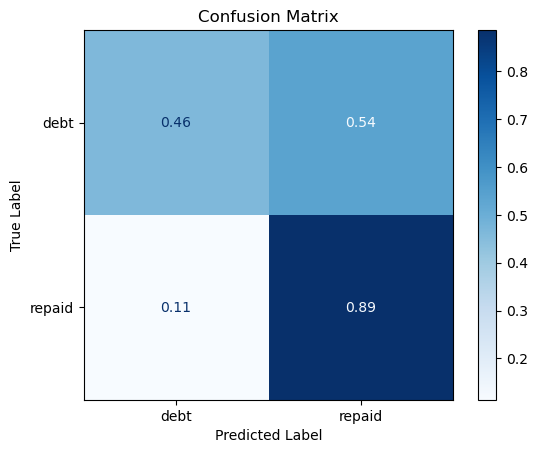

In [9]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class_model1, normalize='true')

# Define the class labels
labels = ['debt', "repaid"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Viewing the confusion matrix and classification report results, we see that the Random Forest (RF) for this problem was much more robust than the Decision Tree. The non-optimized model achieved an weighted f1-score of 0.80 and recall of 0.81, but it stills given more bias for repaid loans, so it is possible to have a better balance by adjusting RF hyperparameters.

## 4 - Creating optimize model

We will use the optuna library to search for the best RF hyperparameters.

Before we apply optuna, let's just notice that for split our data we're using the TimeSeriesSplit because as our data is organize from the earliest date_created to the most recent date_created. This split separates the data preserving this structure as seen below

In [10]:
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_train):
    print("min_date for train split:",train_data.loc[train]["date_created"].min())
    print("max_date for train split:",train_data.loc[train]["date_created"].max())
    print("min_date for test split:",train_data.loc[test]["date_created"].min())
    print("max_date for test split:",train_data.loc[test]["date_created"].max())

min_date for train split: 2022-02-01
max_date for train split: 2022-04-08
min_date for test split: 2022-04-08
max_date for test split: 2022-05-02
min_date for train split: 2022-02-01
max_date for train split: 2022-05-02
min_date for test split: 2022-05-02
max_date for test split: 2022-07-08
min_date for train split: 2022-02-01
max_date for train split: 2022-07-08
min_date for test split: 2022-07-08
max_date for test split: 2022-08-31


In [15]:
def optimize_model(preprocessor:ColumnTransformer,
                   model:RandomForestClassifier,
                   num_trials:int,
                   n_splits:int,
                   params_func:callable,
                   X:Union[pd.DataFrame,np.array],
                   y:Union[pd.DataFrame,np.array])->optuna.study:
    def objective(trial):
        avg_roc = 0
        avg_f1 = 0
        tssplit = TimeSeriesSplit(n_splits=n_splits)
        for tr, ts in tssplit.split(X, y):
            Xtr, Xvl = X.iloc[tr], X.iloc[ts]
            ytr, yvl = y.iloc[tr], y.iloc[ts]
            
            params = params_func(trial)
            
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model(**params))])
            pipe.fit(Xtr, ytr)
            
            yvl_pred_proba = pipe.predict_proba(Xvl)[:,1]
            
            avg_roc += roc_auc_score(yvl, yvl_pred_proba)
            avg_f1 += f1_score(yvl, yvl_pred_proba > 0.5, average='macro')

        print('avg_roc:', avg_roc/n_splits)
        print('macro avg f1:', avg_f1/n_splits)
        
        return avg_roc / n_splits
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective,n_trials=num_trials)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

    return study

def get_params(trial:optuna.trial)->dict:
    params = {
        "max_depth":trial.suggest_int("max_depth",2,5,log=True),
        "min_samples_split":trial.suggest_int("min_samples_split",6,9,log=True),
        "n_estimators":trial.suggest_int("n_estimators",400,500,log=True),
        "criterion":trial.suggest_categorical("criterion",["gini", "entropy", "log_loss"],),
        "class_weight":trial.suggest_categorical("class_weight",["balanced", "balanced_subsample"]),
        "random_state":82
    }
    return params

In [16]:
study = optimize_model(preprocessor=preprocessor,
                       model=RandomForestClassifier,
                       num_trials=20,
                       n_splits=3,
                       params_func=get_params,
                       X=X_train,
                       y=y_train)
best_params = study.best_params

[I 2024-04-09 19:35:55,910] A new study created in memory with name: no-name-1b5f1e10-755a-4dc0-bce4-9194f7cfad2b
[I 2024-04-09 19:36:04,154] Trial 0 finished with value: 0.7352095304587593 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 408, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7352095304587593.


avg_roc: 0.7352095304587593
macro avg f1: 0.6437849749093544


[I 2024-04-09 19:36:15,323] Trial 1 finished with value: 0.7351588690593217 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 462, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7352095304587593.


avg_roc: 0.7351588690593217
macro avg f1: 0.644257552982686


[I 2024-04-09 19:36:24,031] Trial 2 finished with value: 0.7353463025076156 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'n_estimators': 421, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.7353463025076156.


avg_roc: 0.7353463025076156
macro avg f1: 0.6447408677191678


[I 2024-04-09 19:36:30,930] Trial 3 finished with value: 0.7197924124389962 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'n_estimators': 409, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.7353463025076156.


avg_roc: 0.7197924124389962
macro avg f1: 0.6242219060489195


[I 2024-04-09 19:36:40,436] Trial 4 finished with value: 0.7370766686042529 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 480, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7370766686042529
macro avg f1: 0.6431283922116114


[I 2024-04-09 19:36:46,833] Trial 5 finished with value: 0.7197478250308279 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'n_estimators': 439, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7197478250308279
macro avg f1: 0.6251515087370104


[I 2024-04-09 19:36:54,817] Trial 6 finished with value: 0.7193593289511941 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 466, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7193593289511941
macro avg f1: 0.6272182567619607


[I 2024-04-09 19:37:02,475] Trial 7 finished with value: 0.719051573584102 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 404, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.719051573584102
macro avg f1: 0.6262383987605701


[I 2024-04-09 19:37:08,370] Trial 8 finished with value: 0.7197503267577572 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 468, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7197503267577572
macro avg f1: 0.6254993294755852


[I 2024-04-09 19:37:15,024] Trial 9 finished with value: 0.7193933250564101 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 462, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7193933250564101
macro avg f1: 0.6277759360923553


[I 2024-04-09 19:37:23,317] Trial 10 finished with value: 0.7369416218767464 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 497, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7369416218767464
macro avg f1: 0.6457259994980689


[I 2024-04-09 19:37:33,303] Trial 11 finished with value: 0.7369416218767464 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 497, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7369416218767464
macro avg f1: 0.6457259994980689


[I 2024-04-09 19:37:41,871] Trial 12 finished with value: 0.7369442547796647 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 500, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7369442547796647
macro avg f1: 0.6458555467966693


[I 2024-04-09 19:37:48,023] Trial 13 finished with value: 0.7271672879807826 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 484, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7271672879807826
macro avg f1: 0.6358576868367144


[I 2024-04-09 19:37:54,054] Trial 14 finished with value: 0.7272052884718132 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 480, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7272052884718132
macro avg f1: 0.6355321944098639


[I 2024-04-09 19:38:01,677] Trial 15 finished with value: 0.7367414789546749 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 446, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7367414789546749
macro avg f1: 0.6454409576945297


[I 2024-04-09 19:38:10,448] Trial 16 finished with value: 0.7351775881193136 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 483, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7351775881193136
macro avg f1: 0.6431592553390338


[I 2024-04-09 19:38:18,265] Trial 17 finished with value: 0.7369752018566152 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 496, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7369752018566152
macro avg f1: 0.6471825016542861


[I 2024-04-09 19:38:25,465] Trial 18 finished with value: 0.7283530401573387 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'n_estimators': 436, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7283530401573387
macro avg f1: 0.6366950721796746


[I 2024-04-09 19:38:34,335] Trial 19 finished with value: 0.7352185968773224 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'n_estimators': 474, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.7370766686042529.


avg_roc: 0.7352185968773224
macro avg f1: 0.6440264005254465
Number of finished trials: 20
Best trial: {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 480, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}


In [17]:
# Define the pipeline for opt model
# Create the column transformer
preprocessor_for_bm = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES)
        ],
)

model_best_params = best_params
model_best_params["random_state"] = 82

# Define the pipeline
pipeline_for_bm = Pipeline(steps=[
    ('preprocessor', preprocessor_for_bm),  # Preprocessing (imputation + one-hot encoding)
    ('model', RandomForestClassifier(**model_best_params))  # Model
])

# Fit the pipeline to the training data
pipeline_for_bm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['amount', 'total_amount',
                                                   'due_amount',
                                                   'sum_amt_transactions_at_created_loan',
                                                   'sum_amt_payment_method_credit_at_created_loan',
                                                   'sum_amt_payment_method_debit_at_created_loan',
                                                   'sum_amt_transactions_in_visa_at_created_loan',
                                                   'sum_amt_transactions_in_ma...
                                                   'most_frequent_transactions_payment_method_in_last_six_months',
                                                   'most_frequent_loans_repayment_method_in_last_month',
                                                   'most_frequent_loans_repayment_method_in_last_three_months',
                                                   'most_frequent_loans_repayment_method_in_last_six_months'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, min_samples_split=6,
                                        n_estimators=480, random_state=82))])

## 4.1 - Evaluate best model results

In [18]:
y_pred_class_bm = pipeline_for_bm.predict(X_test)

print(classification_report(y_test, y_pred_class_bm,target_names=['debt', 'repaid']))

              precision    recall  f1-score   support

        debt       0.36      0.65      0.46       145
      repaid       0.90      0.73      0.81       624

    accuracy                           0.71       769
   macro avg       0.63      0.69      0.63       769
weighted avg       0.80      0.71      0.74       769



In [19]:
print("Proportion of debt and repaid:")
cat,ncat = np.unique(y_pred_class_bm,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

Proportion of debt and repaid:
0:0.3420026007802341
1:0.657997399219766


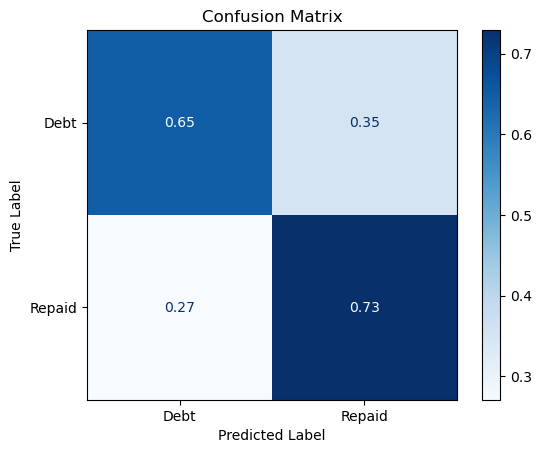

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class_bm, normalize='true')

# Define the class labels
labels = ['Debt', "Repaid"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The optimized version managed to be more balanced with a weighted f1-score of 0.75. From the confusion matrix we also see that the number of hits for debt increased and false negatives decreased, however there was an increase in false negatives.

Based on the tree model, we can also visualize the importance of the features to define who or who did not make the repayment based on the feature importance.

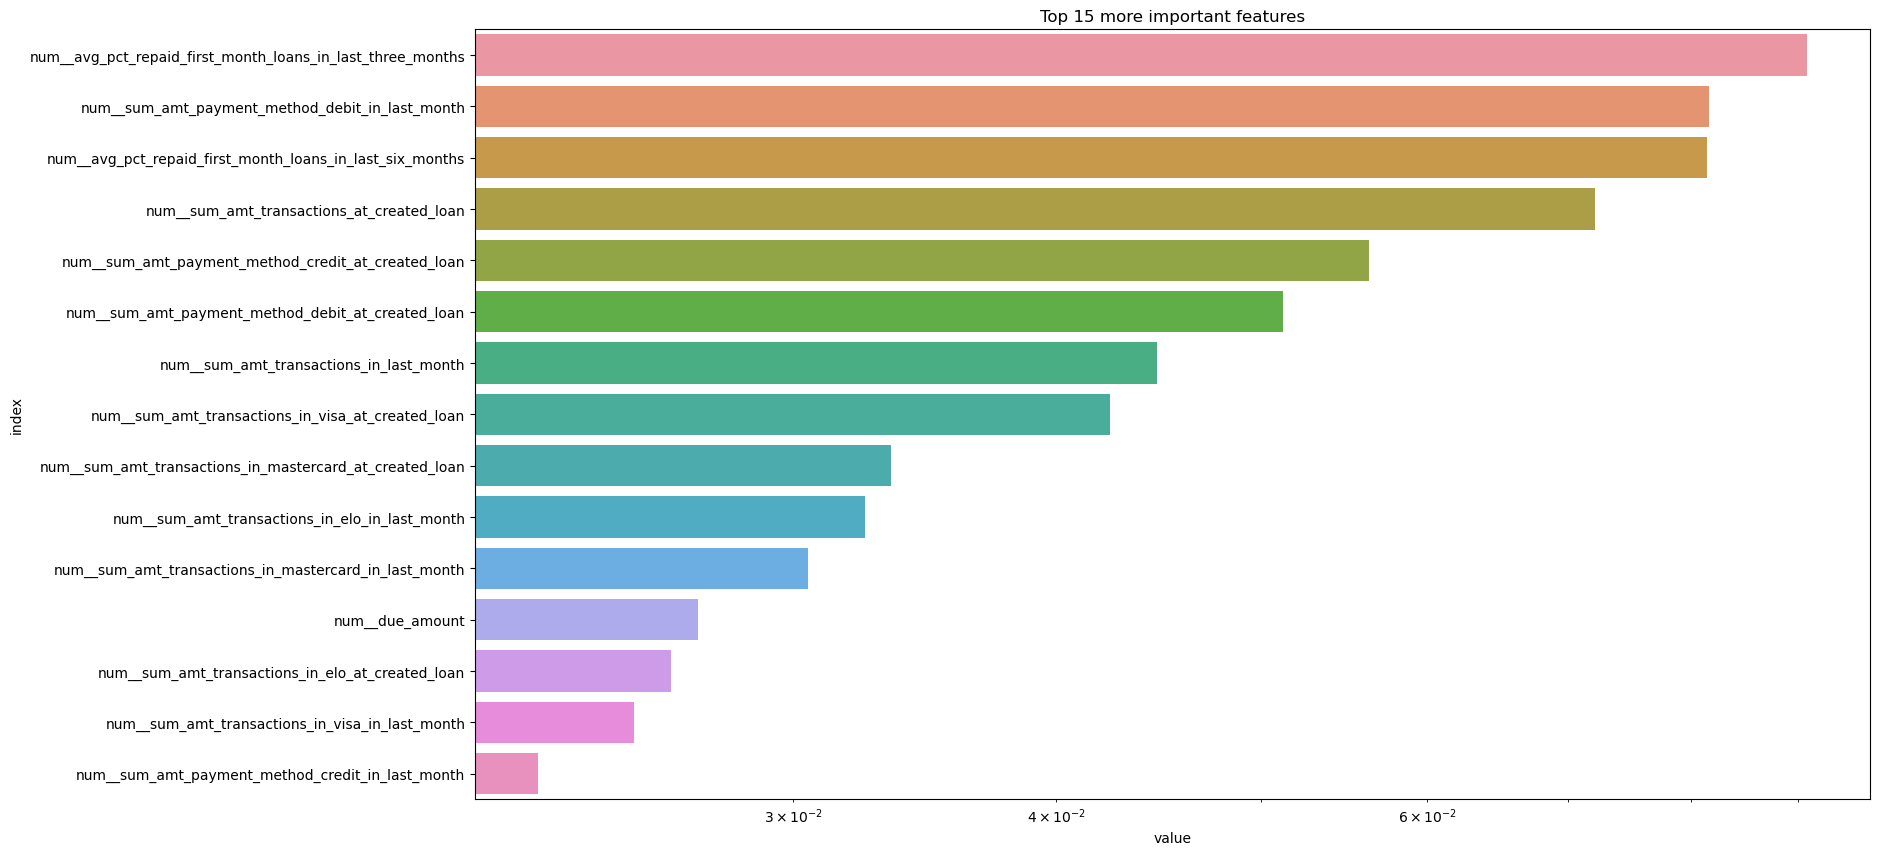

In [21]:
output_feature_names = preprocessor.get_feature_names_out()
best_model_feat_imp = pd.Series(pipeline_for_bm.named_steps.model.feature_importances_,index=output_feature_names)
df_feat_imp_best_model = best_model_feat_imp.reset_index(name="value").sort_values(by="value",ascending=False)


fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(data=df_feat_imp_best_model[:15],y="index",x="value")
ax.set_xscale(value="log")
ax.set_title("Top 15 more important features");

For what we can see, the historical features about loans reapayments from user are really important (`avg_pct_repaid_first_month_loans_in_last_three_months` and `avg_pct_repaid_first_month_loans_in_last_six_months`) also pay attention that features created in the moment a user request a loan have a impact to the model results too. This is important because for a future deployment of the model, we need to ensure that this features will be available.

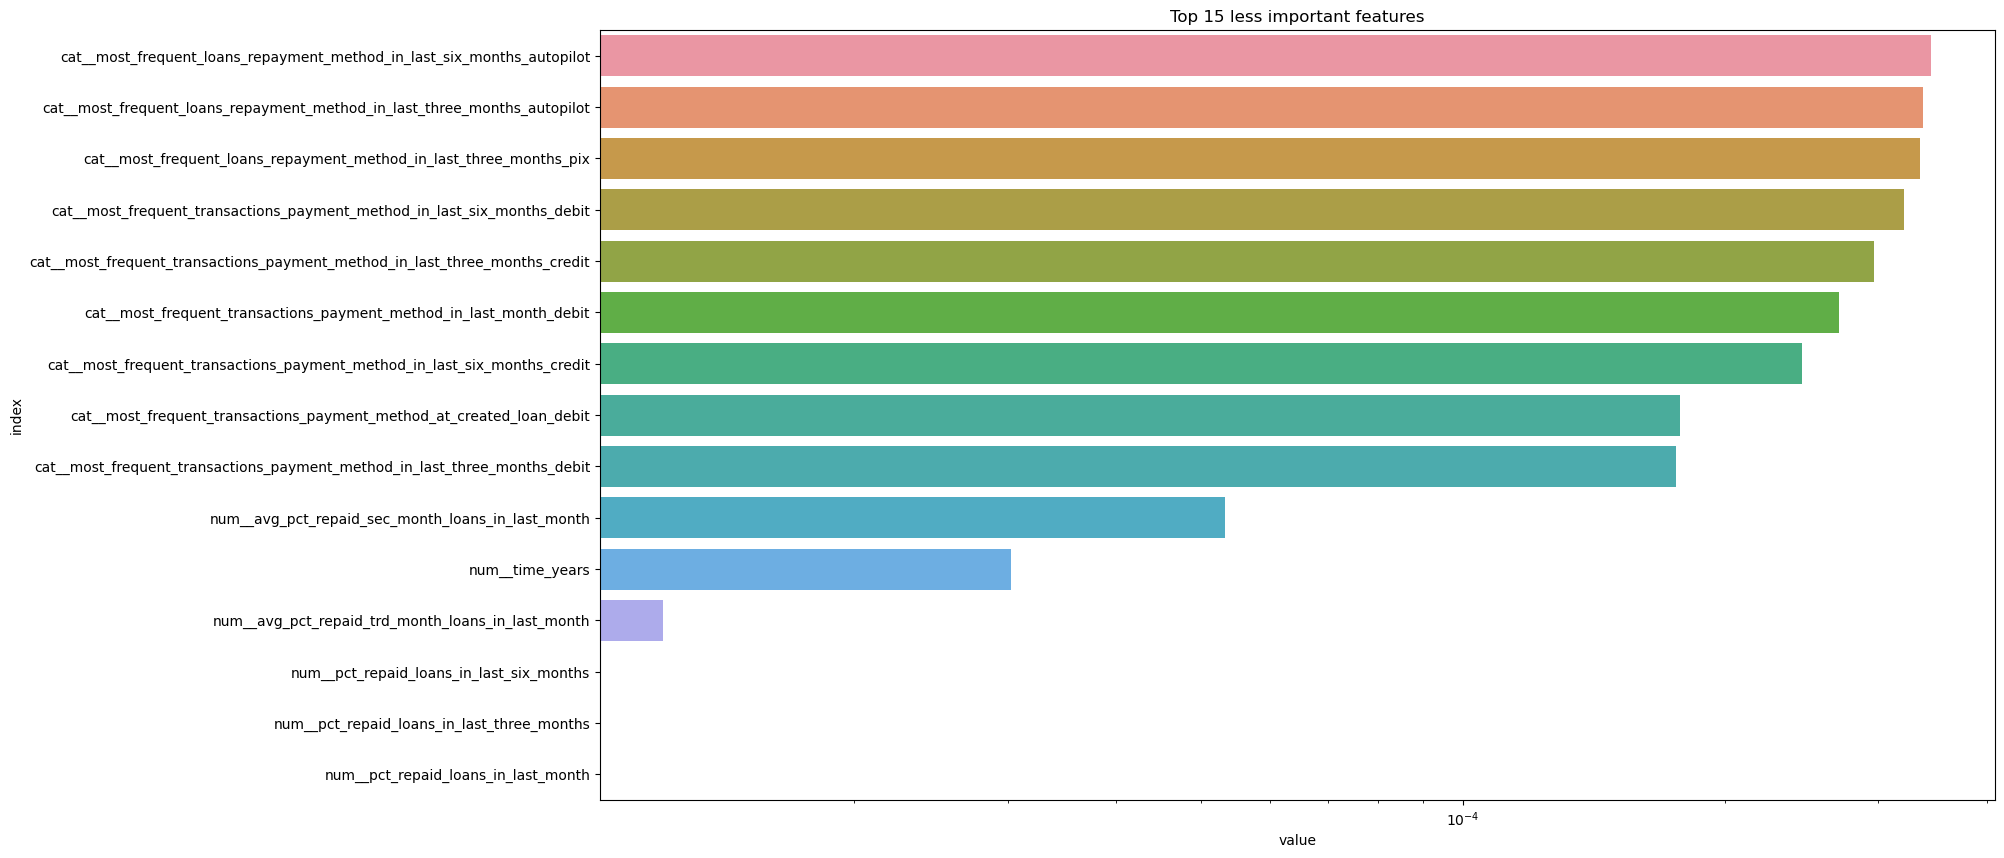

In [22]:
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(data=df_feat_imp_best_model[-15::],y="index",x="value")
ax.set_xscale(value="log")
ax.set_title("Top 15 less important features");

For less important features we see that the historical repayments in the last month and time_years was the least important features, also, all the categorical features have lower impact in the model results.

## 4.2 Save model without FS

In [23]:
OUTPUT_PATH = Path("./config")

num_features = [str.encode(col,encoding="ISO-8859-1") for col in NUM_FEATURES]
cat_features = [str.encode(col,encoding="ISO-8859-1") for col in CAT_FEATURES]
model_name = "random_forest_clf_for_loan_repaymnt_pred_without_fs"
final_th = 0.5

MODEL_PARAMETERS = {
    "model_name":model_name,
    "model_version":1,
    "model_parameters":{
        "fit_params":model_best_params,
        "predict_params":{"decision_threshold":float(final_th)}},
    "model_features":{"NUM_FEATURES":num_features,"CAT_FEATURES":cat_features},
    "model_target":"status"
}


if OUTPUT_PATH.is_dir():
    with open(f"{OUTPUT_PATH}/{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)
else:
    OUTPUT_PATH.mkdir(exist_ok=True,parents=True)
    with open(f"{OUTPUT_PATH}/{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)

## 5 - Feature Selection

One of the important processes for investigation is to select the best features of the model through the feature selection process. As we have a non-linear model, one way to do this process is through Recursive feature elimination (RFE), where the features are selected recursively using cross validation, initially the subset is defined with all the features and then the importance of each one is calculated for the final result of the model is to remove the least relevant features until the minimum required features are reached. As cross-validation occurs, this process is repeated N number of times. The performance of these subsets of features is evaluated by a metric applied to the different quantities of selected features. Finally, the average performance of the N feature subsets is calculated and the one that maximizes the cross-validation metric is selected. ([See scikit-learn doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV))

The advantage of using this with RF is to calculate the importance of the features using the concept of information gain from decision trees and choose the features that most influence the final result.

In [24]:
# model with best_params 

model_for_fs = RandomForestClassifier(**model_best_params)

Xt = preprocessor.transform(X_train)

tscv = TimeSeriesSplit(n_splits=3)

# Apply feature selection
fs = RFECV(
    estimator=model_for_fs,
    step=1,
    min_features_to_select=int(Xt.shape[1]*0.5),
    scoring="roc_auc",
    cv=tscv,
    importance_getter="feature_importances_"
)
fs.fit(Xt,y_train)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
      estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                       max_depth=5, min_samples_split=6,
                                       n_estimators=480, random_state=82),
      importance_getter='feature_importances_', min_features_to_select=38,
      scoring='roc_auc')

In [25]:
output_feature_names = preprocessor.get_feature_names_out()
print("Number of input features:",Xt.shape[1])
print("Number of selected features:",fs.n_features_)
print("Ranking features:")
feat_ranking = pd.Series(fs.ranking_,index=output_feature_names)
feat_ranking.sort_values()

Number of input features: 76
Number of selected features: 42
Ranking features:


num__amount                                                                  1
num__avg_amt_transactions_in_mastercard_in_last_three_months                 1
num__avg_amt_transactions_in_elo_in_last_three_months                        1
num__avg_pct_repaid_first_month_loans_in_last_six_months                     1
num__avg_amt_transactions_in_last_six_months                                 1
                                                                            ..
cat__most_frequent_transactions_payment_method_in_last_month_debit          31
cat__most_frequent_loans_repayment_method_in_last_six_months_autopilot      32
cat__most_frequent_loans_repayment_method_in_last_three_months_autopilot    33
cat__most_frequent_loans_repayment_method_in_last_three_months_pix          34
num__time_years                                                             35
Length: 76, dtype: int64

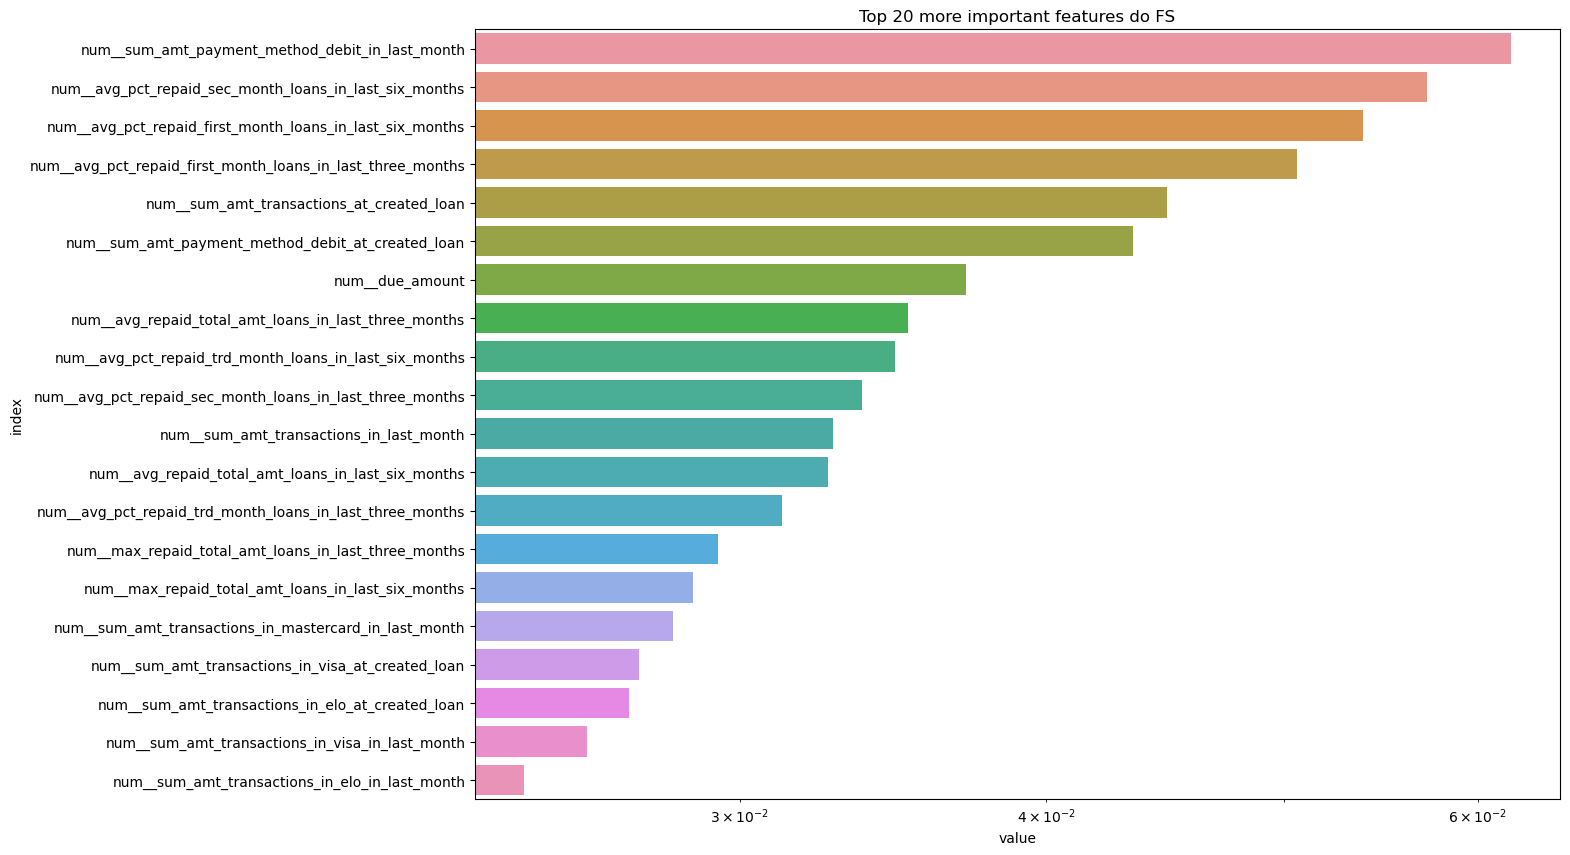

In [26]:
# Checking feature importance
fs_feat_impt = pd.Series(fs.estimator_.feature_importances_,index=output_feature_names[fs.support_])
df_fs_feat_impt = fs_feat_impt.reset_index(name="value").sort_values(by="value",ascending=False)

fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(data=df_fs_feat_impt[:20],y="index",x="value")
ax.set_xscale(value="log")
ax.set_title("Top 20 more important features do FS");

In [27]:
print("Removed features")
rm_feats = set(output_feature_names).difference(set(output_feature_names[fs.support_]))
rm_feats = list(rm_feats)
rm_feats

Removed features


['num__median_installments_in_last_six_months',
 'cat__most_frequent_loans_repayment_method_in_last_three_months_pix',
 'num__pct_repaid_loans_in_last_month',
 'num__pct_repaid_loans_in_last_three_months',
 'num__median_installments_in_last_three_months',
 'cat__most_frequent_transactions_payment_method_in_last_month_debit',
 'cat__most_frequent_transactions_payment_method_at_created_loan_credit',
 'num__max_installments_in_last_six_months',
 'cat__most_frequent_loans_repayment_method_in_last_six_months_autopilot',
 'num__max_amt_transactions_in_last_three_months',
 'cat__most_frequent_transactions_payment_method_at_created_loan_debit',
 'num__max_installments_at_created_loan',
 'num__time_years',
 'num__avg_amt_transactions_in_mastercard_in_last_six_months',
 'cat__most_frequent_loans_repayment_method_in_last_month_autopilot',
 'cat__most_frequent_loans_repayment_method_in_last_month_pix',
 'num__median_installments_in_last_month',
 'cat__most_frequent_loans_repayment_method_in_last_s

In [28]:
# Evaluating the model with feature selection

arr_selected_features = fs.support_

preprocessor_for_fs = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES),
        ],
)

col_selector = ColumnTransformer(
    transformers=[("select_cols","passthrough",arr_selected_features)]
)

pipeline_with_fs = Pipeline(steps=[
    ("column_transformations",preprocessor_for_fs),
    ("select_fs_columns",col_selector),
    ("model",RandomForestClassifier(**model_best_params))
])
pipeline_with_fs.fit(X_train,y_train)

Pipeline(steps=[('column_transformations',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['amount', 'total_amount',
                                                   'due_amount',
                                                   'sum_amt_transactions_at_created_loan',
                                                   'sum_amt_payment_method_credit_at_created_loan',
                                                   'sum_amt_payment_method_debit_at_created_loan',
                                                   'sum_amt_transactions_in_visa_at_created_loan',
                                                   'sum_amt_transact...
        True, False,  True, False, False,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, min_samples_split=6,
                                        n_estimators=480, random_state=82))])

In [29]:
y_pred_class_fs = pipeline_with_fs.predict(X_test)

print(classification_report(y_test, y_pred_class_fs,target_names=['debt', 'repaid']))

              precision    recall  f1-score   support

        debt       0.38      0.62      0.47       145
      repaid       0.90      0.77      0.83       624

    accuracy                           0.74       769
   macro avg       0.64      0.69      0.65       769
weighted avg       0.80      0.74      0.76       769



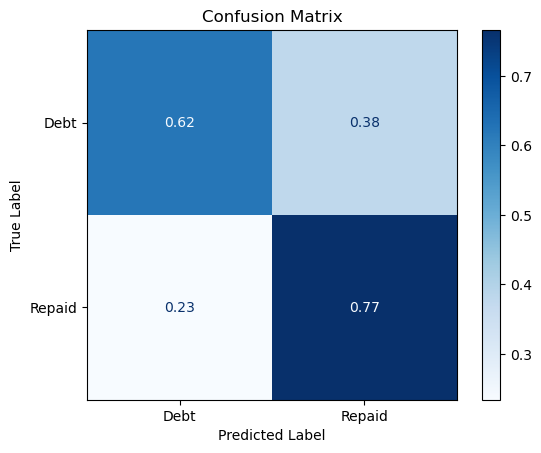

In [30]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class_fs, normalize='true')

# Define the class labels
labels = ['Debt', "Repaid"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 6 - Save best model

In [31]:
OUTPUT_PATH = Path("./config")

num_features = [str.encode(col,encoding="ISO-8859-1") for col in NUM_FEATURES]
cat_features = [str.encode(col,encoding="ISO-8859-1") for col in CAT_FEATURES]
select_cols_arr = fs.support_.tolist()
model_name = "random_forest_clf_for_loan_repaymnt_with_fs"
final_th = 0.5

MODEL_PARAMETERS = {
    "model_name":model_name,
    "model_version":1,
    "model_parameters":{
        "fit_params":model_best_params,
        "fs_params": {"select_cols_arr":select_cols_arr},
        "predict_params":{"decision_threshold":float(final_th)}},
    "model_features":{"NUM_FEATURES":num_features,"CAT_FEATURES":cat_features},
    "model_target":"churn"
}


if OUTPUT_PATH.is_dir():
    with open(f"{OUTPUT_PATH}/{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)
else:
    OUTPUT_PATH.mkdir(exist_ok=True,parents=True)
    with open(f"{OUTPUT_PATH}/{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)

## 7 - Conclusion

- The random forest managed to create a better model than the baselines, this time much less biased to classify a loan as repaid. The model optimized a weighted average f1-score of 0.76, precision at 0.80 and recall at 0.74.
- We can conclude that the built features that have information about the amount of loan payments over time and the history of user transactions made in the month the loan was created and at least in the last month are very important for the model.
- The feature selection process (RFCV) managed to create a slightly more optimized model by also removing the features that were less relevant to the model. This meant a 45% reduction in the non-optimized model and a 1.4% gain in weighted avg recall and 2.7% in weighted avg f1-score.
- As a final model we will only use the features selected by RFCV along with the best parameters found. The settings are in `.\config\random_forest_clf_for_loan_repaymnt_with_fs.yaml`.